<a href="https://colab.research.google.com/github/lee-j-j/LJJ/blob/main/ex16_%EC%95%84%EA%B8%B0%EC%9A%B8%EC%9D%8C%EC%86%8C%EB%A6%AC_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/사물지능A

/content/drive/MyDrive/Colab Notebooks/사물지능A


# 학습목표
  - 소리 데이터를 처리/분석하는 방법을 학습한다.
  - 아기울음소리 분류하는 방법을 학습한다.
    - wav 데이터와 Dense 층만 활용
    - wav 데이터와 Conv1D 층을 활용
    - mfcc 데이터와 Conv2D 층을 활용

- 데이터 압축 풀기

In [2]:
import zipfile

zip_dir = "./data/baby_sound.zip"

zip_ref = zipfile.ZipFile(zip_dir, 'r')
zip_ref.extractall("./data")
zip_ref.close()

In [3]:
!pip install librosa

- wav 파일을 읽어서 출력

In [15]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display

DATA_DIR = "./data/"

# 사운드 파일 읽기
# wav : 사운드 데이터 배열
# sr : sampling rate (초당 데이터수)
wav, sr = librosa.load(DATA_DIR + "WONDERLAND.mp3")

print(f"sr : {sr}")
print(f"데이터 크기 : {wav.shape}")
print(f"플레이 시간 : {wav.shape[0] / float(sr)} 초")


<ipython-input-15-0833122eebd9>:12: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sr = librosa.load(DATA_DIR + "WONDERLAND.mp3")


sr : 22050
데이터 크기 : (4389888,)
플레이 시간 : 199.08789115646258 초


- 플레이

In [7]:
IPython.display.Audio(data=wav, rate=sr)

- 데이터 시각화

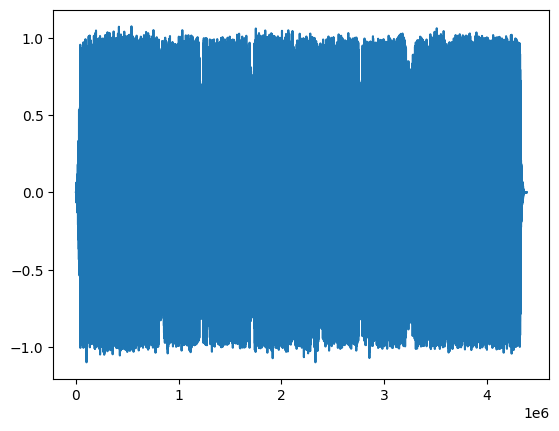

In [16]:
plt.plot(wav)
plt.show()

- 진폭 데이터를 주파수 데이터로 변환
  - 진폭 데이터에는 충분한 소리의 특성을 담을 수가 없기 때문

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=500
  warnings.warn(


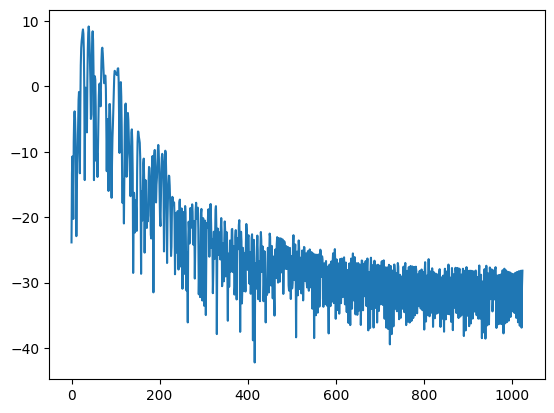

In [17]:
# amplitude_to_db : 진폭 → 데시벨
# stft() : 진폭 → 주파수
# - short time fourier transform
dB = librosa.amplitude_to_db(np.abs(librosa.stft(wav[10000:10500])))

plt.plot(dB.flatten())
plt.show()

- 인간의 귀는 저주파 쪽을 잘 인식하지만 고주파 쪽은 잘 인식하지 못함
  - 저주파 쪽은 샘플링을 많이하고 고주파 쪽은 샘플링을 적게 함 → Melspectrogram

(128, 8575)


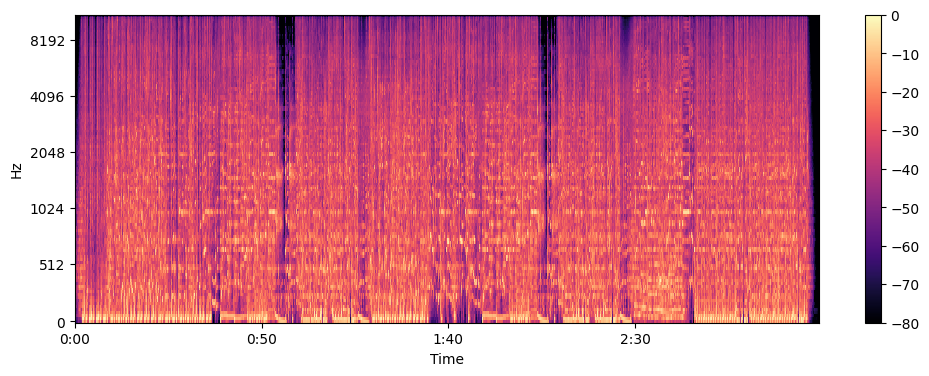

In [18]:
# 주파수 성분 → Melspectrogram으로 변환
# n_mels : y축의 눈금 수 (Melspectrogram의 값을 몇 개로 분리할 것인지)
S = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=128)

print(S.shape)

# 데이터를 시각화
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
# 축의 이름을 고정
librosa.display.specshow(log_S, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar()
plt.show()

- MFCC
  - 멜스펙트로그램을 디지털화 한 것

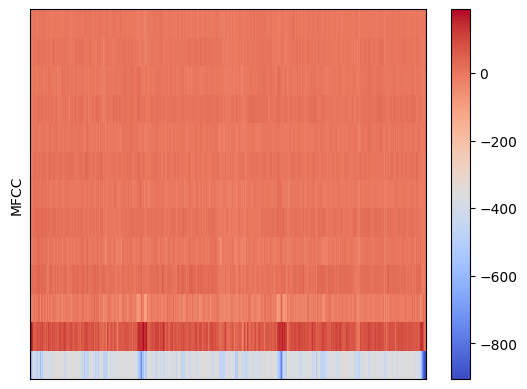

In [21]:
# n_mfcc : 세로축의 눈금수
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

librosa.display.specshow(mfcc)
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

# STT(Speech to Text)
  - 소리 → 텍스트로 변환

In [22]:
!pip install SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 31.4 MB/s eta 0:00:00


In [26]:
import speech_recognition as speech

recognizer = speech.Recognizer()

wav_file = speech.AudioFile("./data/섬집아기.wav")

# wav 파일을 읽어서 저장
with wav_file as w :
  wav = recognizer.record(w)

# wav 데이터로부터 텍스트를 추출
# 한글 : ko-KR
text = recognizer.recognize_google(audio_data=wav, language="ko-KR")

text


'엄마가 섬 그늘에 숨을 따러 가면 아기가 혼자 남아 집을 보다가 불러 주는 노래는 잠을 보니 바보 잊지 마 갈매기 울음소리 잠옷 참 골반 노래 이름 알려 옵니다'

- TTS (Text to Speech)
  - 텍스트 → 음성

In [27]:
!pip install gTTS

In [28]:
from gtts import gTTS

text = "동해물과 백두산이 마르고 닳도록"

tts = gTTS(text=text, lang="ko")

tts.save(DATA_DIR + "result.mp3")

wav, sr = librosa.load(DATA_DIR + "result.mp3")

IPython.display.Audio(data=wav, rate=sr)

# 아기 울음소리 분류
  - 훈련데이터 169개, 테스트데이터 50개
  - 라벨 : crying, laugh, silence
  - 파일명 구조 : 라벨명 (인덱스).wav

- wav데이터(1차원)나 MFCC(2차원) 데이터를 같은 길이로 변환하는 함수
  - 기준 길이보다 긴 데이터 : 기준 길이만큼을 제외하고 뒷부분을 자름
  - 기준 길이보다 짧은 데이터 : 기준 길이와의 차이만큼 0을 채워서 뒷부분에 추가

In [30]:
# wav : 소리데이터 , th : 기준 길이
def pad1d(wav, th) :
  # 기준 길이보다 긴 데이터
  if wav.shape[0] > th:
    return wav[:th]
  # 기준 길이보다 짧은 데이터
  else:
    # hstack() : 가로 방향으로 데이터를 연결
    # th - wav.shape[0] : wav와 기준길이의 차이
    return np.hstack(wav, np.zeros(th - wav.shape[0]))

In [31]:
pad1d(wav, 4)

array([ 7.8779146e-14,  3.1557940e-14, -7.2552478e-13, -2.8303093e-12],
      dtype=float32)

In [40]:
# 2차원 데이터 (MFCC)
def pad2d(wav, th) :
  if wav.shape[1] > th:
    return wav[:, :th]

  else:
    return np.hstack(wav, np.zeros(wav.shape[0], th - wav.shape[1]))

- 데이터 전처리
  - 사운드데이터 로드
  - 파일명에서 라벨 분리해서 저장
  - wav를 동일한 길이로 맞추어서 저장

In [46]:
TRAIN_DIR = "./data/train/"
TEST_DIR = "./data/test/"


In [48]:
import os
# 파일을 하나씩 불러와서 라벨과 특성데이터로 저장
X_train = []
y_train = []
X_test =[]
y_test = []

for fname in os.listdir(TRAIN_DIR):
  # 파일명에서 라벨을 분리
  # 파일구조 : 라벨 (인덱스).wav
  label = fname.split(" ")[0]
  # 라벨을 저장
  y_train.append(label)

  wav, sr = librosa.load(TRAIN_DIR + fname)
  # wav를 30000개 데이터씩 자름
  pad_x = pad1d(wav, 30000)
  X_train.append(pad_x)

print(len(X_train), len(y_train))

for fname in os.listdir(TEST_DIR):
  label = fname.split(" ")[0]
  y_test.append(label)

  wav , sr = librosa.load(TEST_DIR + fname)
  pad_x = pad1d(wav, 30000)
  X_test.append(pad_x)

print(len(X_test), len(y_test))

169 169
89 89


- 리스트 → 배열로 변환

In [49]:
import pandas as pd

X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

In [50]:
X_train.shape, X_test.shape

((169, 30000), (89, 30000))

- 라벨 데이터 원핫인코딩

In [51]:
y_train_en = pd.get_dummies(y_train)
y_test_en = pd.get_dummies(y_test)

y_train_en.shape, y_test_en.shape

((169, 3), (89, 3))

- 신경망 설계

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model1 = Sequential()

model1.add(Dense(512, input_shape=X_train[0].shape, activation="relu"))
model1.add(Dense(256, activation="relu"))
model1.add(Dense(128, activation="relu"))
model1.add(Dense(64, activation="relu"))

model1.add(Dense(3, activation="softmax"))

In [53]:
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [54]:
h1 = model1.fit(X_train, y_train_en, epochs=50, batch_size=32, validation_data=(X_test, y_test_en))

Epoch 1/50
6/6 [==============================] - 4s 455ms/step - loss: 0.8790 - accuracy: 0.5325 - val_loss: 0.7664 - val_accuracy: 0.5393
Epoch 2/50
6/6 [==============================] - 2s 303ms/step - loss: 0.6219 - accuracy: 0.7574 - val_loss: 0.9317 - val_accuracy: 0.6854
Epoch 3/50
6/6 [==============================] - 1s 253ms/step - loss: 0.2687 - accuracy: 0.9882 - val_loss: 1.4192 - val_accuracy: 0.6180
Epoch 4/50
6/6 [==============================] - 2s 263ms/step - loss: 0.1460 - accuracy: 0.9941 - val_loss: 1.7869 - val_accuracy: 0.6404
Epoch 5/50
6/6 [==============================] - 2s 266ms/step - loss: 0.0774 - accuracy: 1.0000 - val_loss: 2.0736 - val_accuracy: 0.6742
Epoch 6/50
6/6 [==============================] - 2s 342ms/step - loss: 0.0414 - accuracy: 1.0000 - val_loss: 2.6315 - val_accuracy: 0.6742
Epoch 7/50
6/6 [==============================] - 2s 305ms/step - loss: 0.0201 - accuracy: 1.0000 - val_loss: 3.4025 - val_accuracy: 0.6180
Epoch 8/50
6/6 [====